# CASA Summary
The pipeline used for calibration and flagging closely follows that of the CASA pipeline (https://casaguides.nrao.edu/index.php?title=VLA-S-CASA_Pipeline-CASA6.2.1#Stage_7._hifv_checkflag:_Flag_possible_RFI_on_BP_calibrator_using_rflag). This notebook summarises the output of the pipeline (calibration tables, flagging summaries, data plots) and can be used to get an overview of the data and identify bad data that needs to be flagged manually.

In [1]:
import os
import sys
import h5py
import yaml
import casatasks
import numpy as np
from astropy.time import Time
import astropy.units as u
from ipywidgets import interact

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.viridis  
cmap.set_bad(color='red')

from IPython.display import Image

# read yaml file
with open("../input/config.yaml", "r") as file:
    conf = yaml.safe_load(file)
    
sys.path.append(os.path.join(os.curdir, "../"))

from vlapy import vladata, inspect

## Obervation Information 
The data below is the output of CASA's listobs task and can be used to fill in the yaml file "obs.yaml", which contains all the parameters for the pipeline.

In [2]:
obs = conf["obs list"][1]
root = os.path.join(conf["root"], f"{obs}")
name = obs.split(".")[0]

ms = os.path.join(root, f"{obs}_hanning.ms")
vladata.listobs(ms)

BeginTime
58741.80712962962 

EndTime
58741.88398148149 

IntegrationTime
6640.000001907349 

field_0
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 1.4948845339}, 'm1': {'unit': 'rad', 'value': 0.8700817014000001}, 'refer': 'J2000', 'type': 'direction'}
name :  3C147


field_1
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.8707328287}, 'm1': {'unit': 'rad', 'value': -0.4287152683}, 'refer': 'J2000', 'type': 'direction'}
name :  J1057-2433


field_10
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.6722909513795865}, 'm1': {'unit': 'rad', 'value': 0.2145021233}, 'refer': 'J2000', 'type': 'direction'}
name :  J1347+1217


field_11
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': -2.6959439184795864}, 'm1': {'unit': 'rad', 'value': 0.1654116891}, 'refer': 'J2000', 'type': 'direction'}
name :  QSO J1342+0928


field_2
code :  NONE
direction :  {'m0': {'unit': 'rad', 'value': 2.7697284398}, 'm1': {'unit': 'rad', 'value': -0.2516938345}, 'refer':

### Array Layout

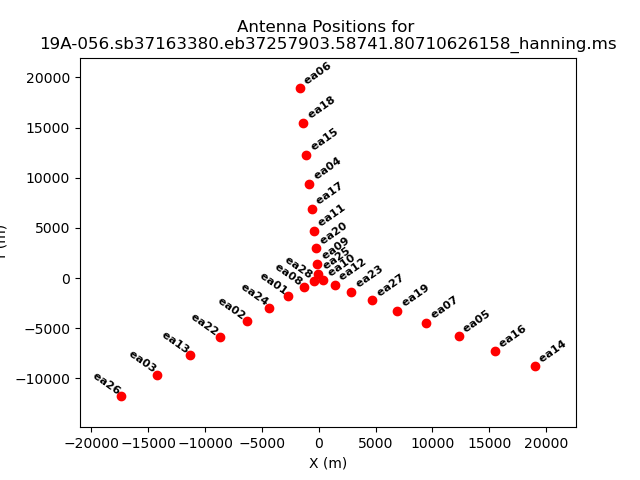

In [3]:
Image(filename=root + "/plots/obsplots/antlayout.png")

### Plot Elevation vs. Time
Observations low in elevation might see more RFI. The plot is colorised by field. Each target field is in between two phase calibrators.

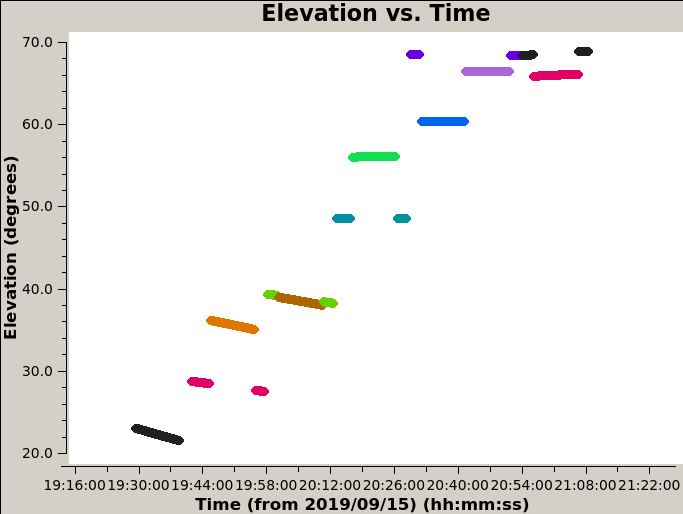

In [4]:
Image(filename=root + "/plots/obsplots/elevation_vs_time.png")

## VLA Deterministic Flags and Manual Flags
These include antennas not on source, shadowed antennas, scans with non-relevant intents, autocorrelations, edge channels of spectral windows, edge channels of the baseband, clipping absolute zero values produced by the correlator and the first few integrations of a scan (quacking). Manual flags are also applied for data known to be bad (RFI, obs reports). Below is a summary of the flags before and after applying the deterministic flags. Use the flagging frequency to find a suitable reference antenna and specify it in the yaml file.

In [5]:
summary_before = np.load(root + "/output/detflag_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/detflag_summary_after.npy", allow_pickle='TRUE').item()

# print flagging summary
def print_summary(item):
    for subitem in summary_before[item]:
        print(f"{item} {subitem}")
        print(
            "Before: {:.4f}, After: {:.4f}".format(
                100.0 * summary_before[item][subitem]["flagged"] / summary_before[item][subitem]["total"],
                100.0 * summary_after[item][subitem]["flagged"] / summary_after[item][subitem]["total"],
            )
        )
        print("")
        
print("Flag occupancy (percent) before and after deterministic flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after deterministic flags:

field 3C147
Before: 36.3357, After: 49.6085

field J1057-2433
Before: 35.6709, After: 48.6051

field J1130-1449
Before: 16.6981, After: 33.4382

field J1246-0730
Before: 17.5671, After: 34.1113

field J1309+1154
Before: 23.0897, After: 38.5024

field J1347+1217
Before: 16.0921, After: 32.9387

field QSO J1034-1425
Before: 6.5930, After: 25.3261

field QSO J1110-1329
Before: 5.0797, After: 24.1343

field QSO J1254-0014
Before: 6.5487, After: 25.2888

field QSO J1306+0356
Before: 6.7947, After: 25.4818

field QSO J1319+0950
Before: 5.9436, After: 24.8055

field QSO J1342+0928
Before: 4.4206, After: 23.5877

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 17.3399, After: 33.9260

scan 11
Before: 6.5487, After: 25.2888

scan 12
Before: 17.9294, After: 34.4068

scan 13
Before: 33.6432, After: 46.9030

scan 14
Before: 6.7947, After: 25.4818

scan 15
Before: 5.9436, After: 24.8055

scan 16
Before: 10.3968, After: 28.398

### Plot Online Flags
Plot flaggingreason vs. time. This shows which antennas are flagged due to focus errors, subreflector errors and antenna not on source. This plot can help identify suitable reference antennas.

In [6]:
if os.path.exists(root+"/plots/dataplots/flaggingreason_vs_time.png"):
    Image(filename=root+"/plots/dataplots/flaggingreason_vs_time.png")

### Plot Antenna Data Stream
If an antenna has missing data, it should not be used as a reference.

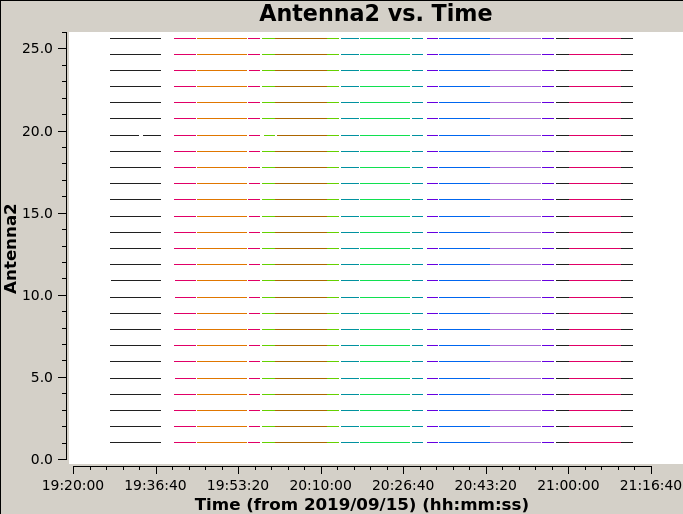

In [7]:
Image(filename=root + "/plots/obsplots/data_stream.png")

## Find Dead Antennas
Antennas that have low power should be flagged. This is also a good time to check for suitable reference antennas.

In [8]:
def plot_dead_ants(ant):
    plotfile = root + f"/plots/dataplots/find_dead_ants_amp_vs_freq_ant_{ant}.png"
    img = mpimg.imread(plotfile)
    plt.imshow(img)
    
interact(plot_dead_ants, ant=(1, 26))
    

interactive(children=(IntSlider(value=13, description='ant', max=26, min=1), Output()), _dom_classes=('widget-…

<function __main__.plot_dead_ants(ant)>

## RFI Inspection
The visibility amplitudes are first averaged across baselines and polarisation products. A modified Z-score is then computed across time as $Z_i = \frac{x_i - \mathrm{med}\{x_i\}_i}{\sigma_\mathrm{MAD}}$, 

where $\sigma_\mathrm{MAD} = \mathrm{med}\{\left|x_i - \mathrm{med}\{x_i\}_i\right|\}$ is the Median Absolute Deviation (MAD), and $x_i$ is the data (visibility amplitude) of the $i^\mathrm{th}$ integration.

The resulting Z-score is a spectrogram with dimensions of time and frequency. It can further be averaged across one of these dimensions to obtain a time series or a spectrum, which are useful for identifying broadband and persistent narrowband RFI respectively.

Use this to identify one clean channel per spectral window which will be used for the initial gain calibration.

#### Load Data

In [9]:

with h5py.File(root + f"/output/z_score_data.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

#### Plot

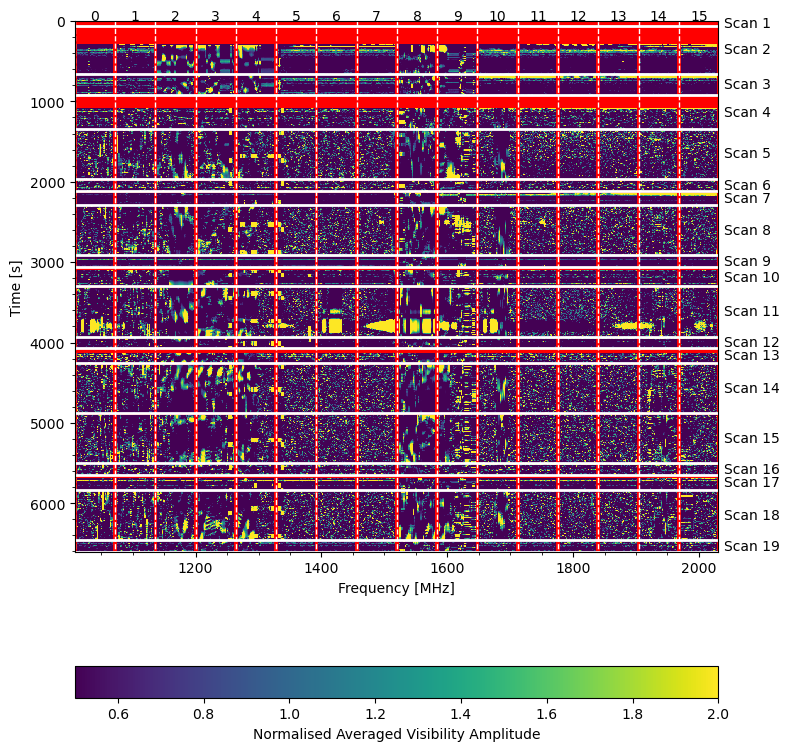

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=0.5, vmax=2, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", label="Normalised Averaged Visibility Amplitude")
plt.tight_layout()
plt.show()

In [11]:
def plot_wf_spw(i):
    inspect.plot_wf_spw(freq_array, z_score, i, 2, ntimes, plot_masked=True)
    
interact(plot_wf_spw, i=(0, 15))

interactive(children=(IntSlider(value=7, description='i', max=15), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_wf_spw(i)>

In [12]:
summary_before = np.load(root + "/output/manual_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + "/output/manual_flags_summary_after.npy", allow_pickle='TRUE').item()
        
print("Flag occupancy (percent) before and after manual flags:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after manual flags:

field 3C147
Before: 74.3967, After: 74.3967

field J1057-2433
Before: 74.1120, After: 74.1120

field J1130-1449
Before: 65.9782, After: 65.9782

field J1246-0730
Before: 66.4005, After: 66.4005

field J1309+1154
Before: 69.7353, After: 69.7353

field J1347+1217
Before: 66.1378, After: 66.1378

field QSO J1034-1425
Before: 61.2360, After: 61.2360

field QSO J1110-1329
Before: 60.4817, After: 60.4817

field QSO J1254-0014
Before: 61.6085, After: 61.6085

field QSO J1306+0356
Before: 61.0386, After: 61.0386

field QSO J1319+0950
Before: 60.2318, After: 60.2318

field QSO J1342+0928
Before: 59.7095, After: 59.7095

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 66.6765, After: 66.6765

scan 11
Before: 61.6085, After: 61.6085

scan 12
Before: 65.9604, After: 65.9604

scan 13
Before: 74.1945, After: 74.1945

scan 14
Before: 61.0386, After: 61.0386

scan 15
Before: 60.2318, After: 60.2318

scan 16
Before: 64.3722, After: 64.3

## Flux Calibrator Model
Print model flux densities and plot model amplitude vs. uv-distance. If the calibrator is not resolved, its amplitude should be constant across different uv-distances. If it is slightly resolved, the amplitude will decrease as a function of uv-distance.

In [13]:
setjy = np.load(root + "/output/setjy.npy", allow_pickle='TRUE').item()

print("model flux densities in Jy\n")

for spw in range(16):
    print("SPW {:2d}: I: {:.2f}, U: {:.2f}, V: {:.2f}, Q: {:.2f}".format(spw, *setjy["0"][str(spw)]["fluxd"]))

model flux densities in Jy

SPW  0: I: 28.13, U: 0.00, V: 0.00, Q: 0.00
SPW  1: I: 26.94, U: 0.00, V: 0.00, Q: 0.00
SPW  2: I: 25.85, U: 0.00, V: 0.00, Q: 0.00
SPW  3: I: 24.85, U: 0.00, V: 0.00, Q: 0.00
SPW  4: I: 23.92, U: 0.00, V: 0.00, Q: 0.00
SPW  5: I: 23.06, U: 0.00, V: 0.00, Q: 0.00
SPW  6: I: 22.27, U: 0.00, V: 0.00, Q: 0.00
SPW  7: I: 21.52, U: 0.00, V: 0.00, Q: 0.00
SPW  8: I: 20.83, U: 0.00, V: 0.00, Q: 0.00
SPW  9: I: 20.18, U: 0.00, V: 0.00, Q: 0.00
SPW 10: I: 19.57, U: 0.00, V: 0.00, Q: 0.00
SPW 11: I: 19.00, U: 0.00, V: 0.00, Q: 0.00
SPW 12: I: 18.46, U: 0.00, V: 0.00, Q: 0.00
SPW 13: I: 17.95, U: 0.00, V: 0.00, Q: 0.00
SPW 14: I: 17.47, U: 0.00, V: 0.00, Q: 0.00
SPW 15: I: 17.02, U: 0.00, V: 0.00, Q: 0.00


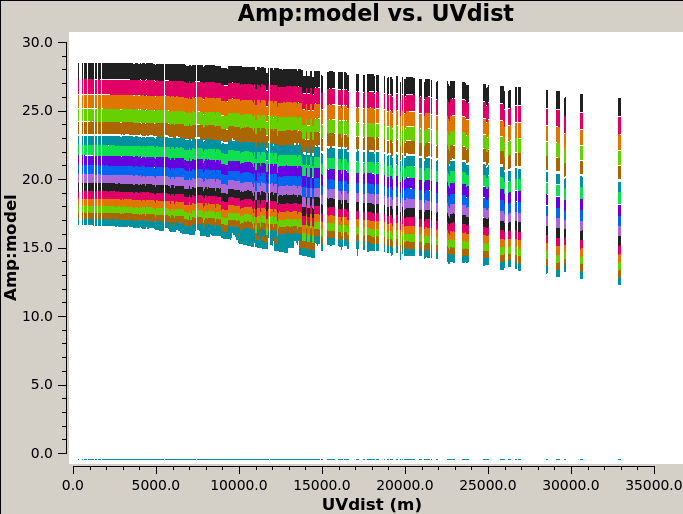

In [14]:
Image(filename=root + "/plots/calplots/setjy_model_amp_vs_uvdist.png")

## Prior Calibration

The prior calibration includes atmospheric opacity corrections, antenna offset corrections and requantizer (rq) gains. These are independent of calibrator observations and use external data instead.

### Weather
Plot weather data and print opacities. For frequencies below 10 GHz the opacity is negligibly small.  

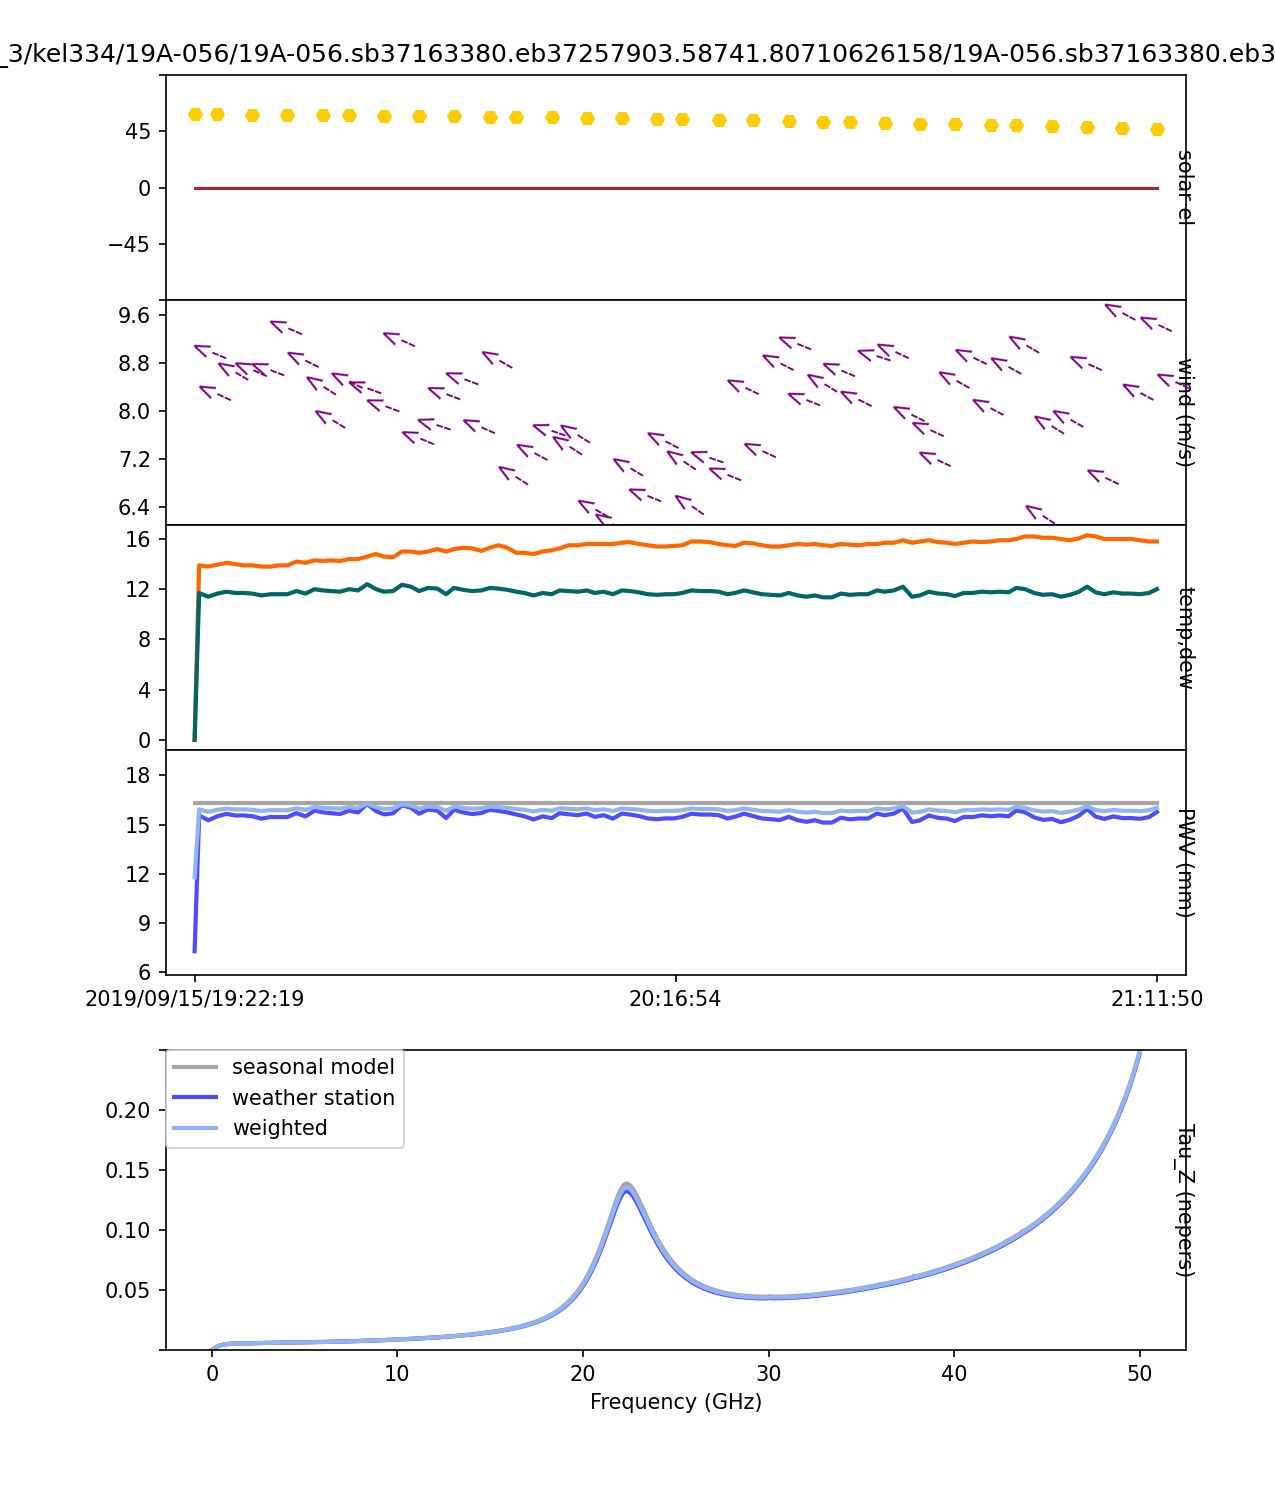

In [15]:
Image(filename=root + "/plots/calplots/weather.png")

In [16]:
opacities = np.load(root + "/output/weather.npy")

print("Opacities [Nepers]\n")

for spw, opacity in enumerate(opacities):
    print(f"SPW {spw}: {opacity}")

Opacities [Nepers]

SPW 0: 0.005155720330169471
SPW 1: 0.005215975540356473
SPW 2: 0.0052684612708354525
SPW 3: 0.005314402490744539
SPW 4: 0.005355236511163486
SPW 5: 0.005391560722944433
SPW 6: 0.005424306055528999
SPW 7: 0.005453947175697299
SPW 8: 0.005481013436487306
SPW 9: 0.005505911649112115
SPW 10: 0.005528932317589208
SPW 11: 0.005550422139566428
SPW 12: 0.0055705301911465775
SPW 13: 0.005589535562971168
SPW 14: 0.005607549300856748
SPW 15: 0.005624749733186012


## Plot Calibration Channels
These are the channels that have been selected for the gain calibration. They should be clean and should not exhibit any amplitude jumps.

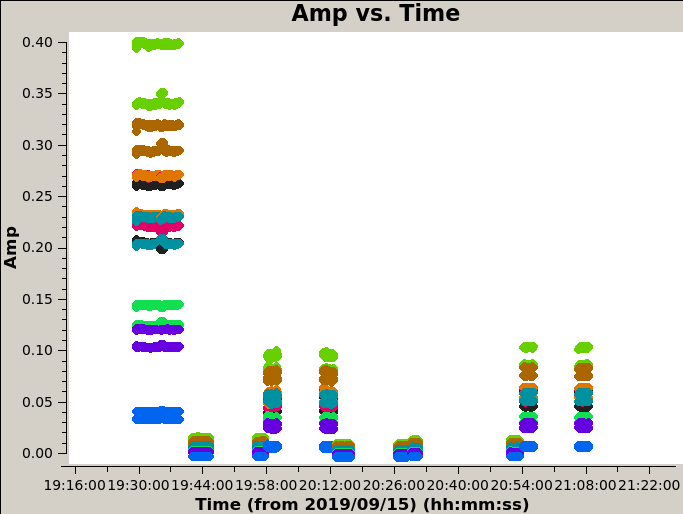

In [17]:
Image(filename=root + "/plots/dataplots/single_chans_amp_vs_time.png")

## Initial Calibration
The initial calibration is done to enable subsequent flagging with automated flagging routines such as CASA's RFlag. The calibration consists of an initial gain phase calibration, a delay calibration, an initial gain phase and amplitude calibration and a bandpass calibration. The two gain calibrations are used for the delay and bandpass calibrations, but are not applied to the data. The gain calibrations are done with a single channel per spectral window.

In [18]:
def plot_two_cols(im1, im2):
    """ 
    Plot two image side by side. E.g phase and amplitude.
    """
    fix, ax = plt.subplots(1, 2, figsize=(15, 5))

    if os.path.exists(im1):
        img_1 = mpimg.imread(im1)
        ax[0].imshow(img_1)

    if os.path.exists(im2):
        img_2 = mpimg.imread(im2)
        ax[1].imshow(img_2)

### Specify Gain Tables

In [19]:
# specify calibration table names
rnd = 0
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration
This is an initial per-integration phase calibration and is done to avoid decorrelation under temporal averaging in the subsequent delay calibration. The gain phase should be stable in time. Antennas or spectral windows that have gain phase discontinuities should be flagged. If all but the reference antenna exhibit phase jumps, a difference reference antenna should be chosen.

In [20]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration
The delay calibration is done by fitting for the phase slopes across frequency with respect to the reference antenna. The first and last 15 channels of the spectral windows are not used in this step, since they have lower gains. The delays should lie between -5 and 5 ns, and anything outside that range should be treated with suspicion.

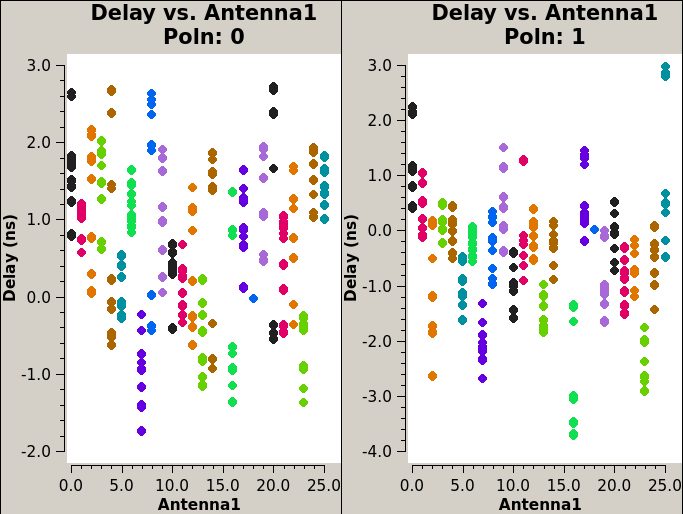

In [21]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration
Similarly to above, we perform an initial gain calibration for the bandpass calibration, but this time we also solve for the amplitudes. The phases and amplitudes should be constant with time and discontinuous solutions should be flagged.

In [22]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration
The amplitudes and phases of the bandpass calibration should be close to 1 and zero respectively after the initial gain calibration. Discontinuities should be flagged.

In [23]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [24]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Plot Corrected Data
This data is averaged in time and colorised by antenna.

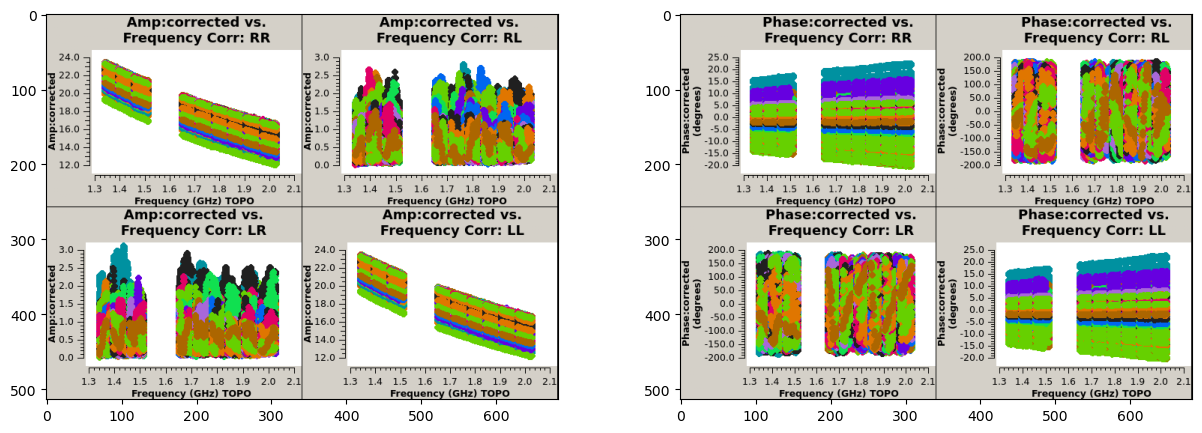

In [25]:
plot_two_cols(
    root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_CorrRR,RL,LR,LL.png",
    root + f"/plots/dataplots/fluxcal_initcal_round_0_phase_vs_freq_CorrRR,RL,LR,LL.png"
)

#### Plot Averaged Corrected Data
Iterate through spectral windows to identify RFI and flag bad channels manually below.

In [26]:
def plot_corrected_spw(spw):
    img = mpimg.imread(root + f"/plots/dataplots/fluxcal_initcal_round_0_amp_vs_freq_avg_spw_{spw}_CorrRR,RL,LR,LL.png")
    plt.imshow(img)

interact(plot_corrected_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_corrected_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [27]:
rnd=0
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 0:

field 3C147
Before: 74.3967, After: 74.3969

antenna ea01
Before: 72.2239, After: 72.2241

antenna ea02
Before: 72.1637, After: 72.1638

antenna ea03
Before: 72.1747, After: 72.1748

antenna ea04
Before: 72.1482, After: 72.1483

antenna ea05
Before: 72.1277, After: 72.1278

antenna ea06
Before: 72.2662, After: 72.2663

antenna ea07
Before: 72.2277, After: 72.2279

antenna ea08
Before: 72.2503, After: 72.2505

antenna ea09
Before: 72.1956, After: 72.1957

antenna ea10
Before: 72.2623, After: 72.2625

antenna ea11
Before: 72.1381, After: 72.1382

antenna ea12
Before: 72.4952, After: 72.4954

antenna ea13
Before: 72.1790, After: 72.1791

antenna ea14
Before: 72.1694, After: 72.1695

antenna ea15
Before: 72.1733, After: 72.1734

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 72.2953, After: 72.2955

antenna ea18
Before: 73.8440, After: 73.8442

antenna ea19
Before: 72.2978, After: 72.2979

antenna

## First Round of Flagging on Primary Calibrator
The first round of flagging is performed on the primary calibrator only. The flagging routine runs RFlag with timedevscale=5.0, freqdevscale=5.0 and freqfit=line on a ABS_RL, ABS_LR, ABS_LL, ABS_RR, REAL_LL, REAL_RR, IMAG_LL and IMAG_RR, where for the real and imaginary parts RFLag is performed on the residual (corrected-model) data. TFCrop is run with timecutoff=4.0 and freqcutoff=4.0 on ABS_RL, ABS_LR, ABS_LL and ABS_RR. Flags are extended across polarisations. The plots below show the amplitudes and phases of the calibrators before and after flagging respectively.

### Before Flagging

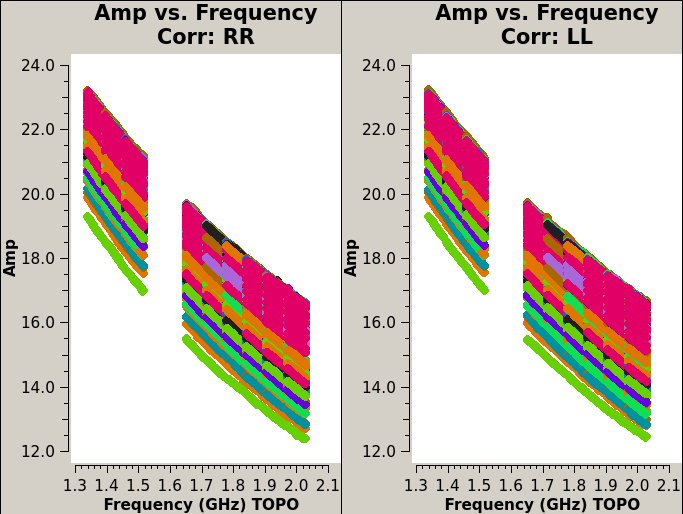

In [28]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

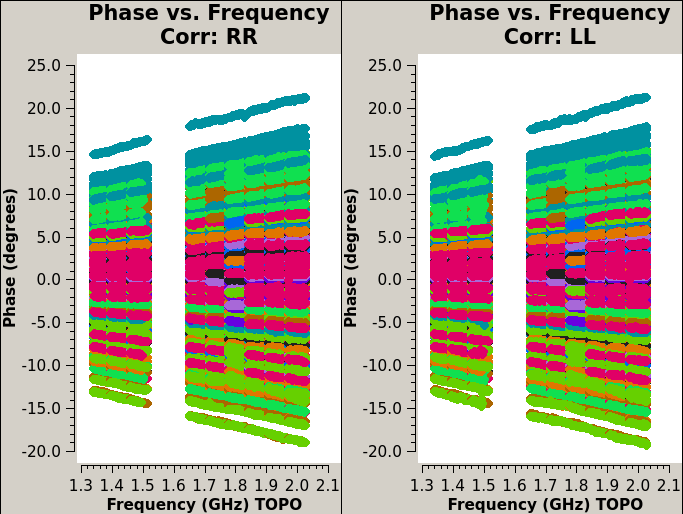

In [29]:
Image(filename=root + "/plots/dataplots/before_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

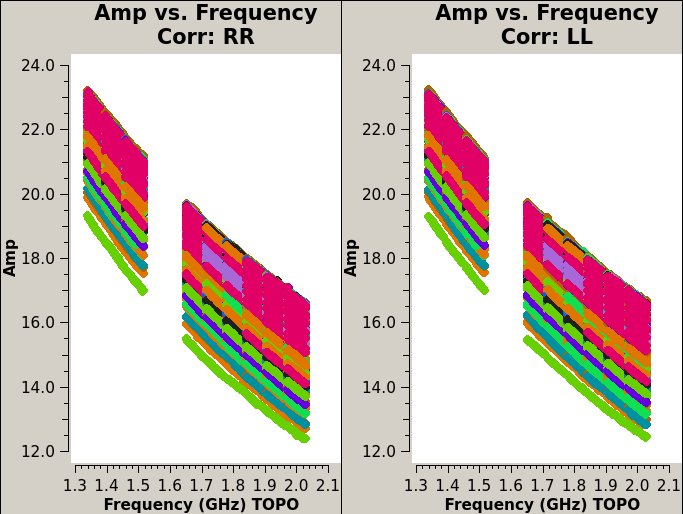

In [30]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

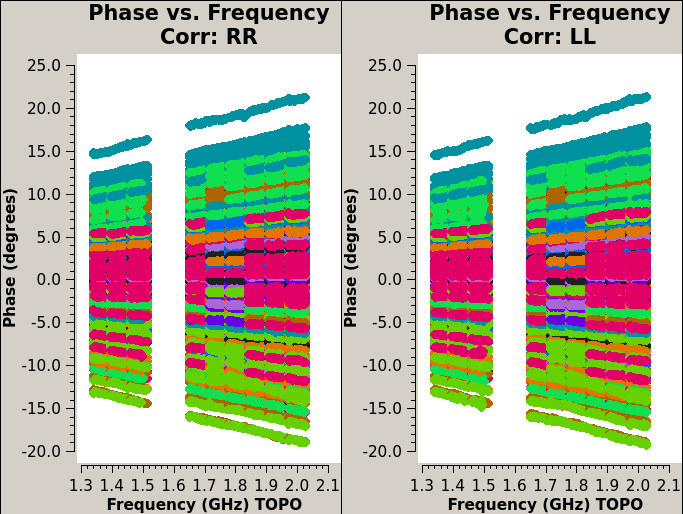

In [31]:
Image(filename=root + "/plots/dataplots/after_fluxcal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Summary

In [32]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C147
Before: 74.3969, After: 74.4948

antenna ea01
Before: 72.2241, After: 72.3255

antenna ea02
Before: 72.1638, After: 72.2673

antenna ea03
Before: 72.1748, After: 72.2860

antenna ea04
Before: 72.1483, After: 72.2564

antenna ea05
Before: 72.1278, After: 72.2324

antenna ea06
Before: 72.2663, After: 72.3840

antenna ea07
Before: 72.2279, After: 72.3343

antenna ea08
Before: 72.2505, After: 72.3533

antenna ea09
Before: 72.1957, After: 72.3014

antenna ea10
Before: 72.2625, After: 72.3712

antenna ea11
Before: 72.1382, After: 72.2437

antenna ea12
Before: 72.4954, After: 72.6040

antenna ea13
Before: 72.1791, After: 72.2905

antenna ea14
Before: 72.1695, After: 72.2795

antenna ea15
Before: 72.1734, After: 72.2789

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 72.2955, After: 72.4077

antenna ea18
Before: 73.8442, After: 74.0175

antenna ea19
Before: 72.2979, After: 72.4060

antenn

## Semi-Final Calibration
The steps from the intitial calibration are repeated. 

### Specify Gain Tables

In [33]:
# specify calibration table names
rnd = 1
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

### Delay Initial Gain Calibration

In [34]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

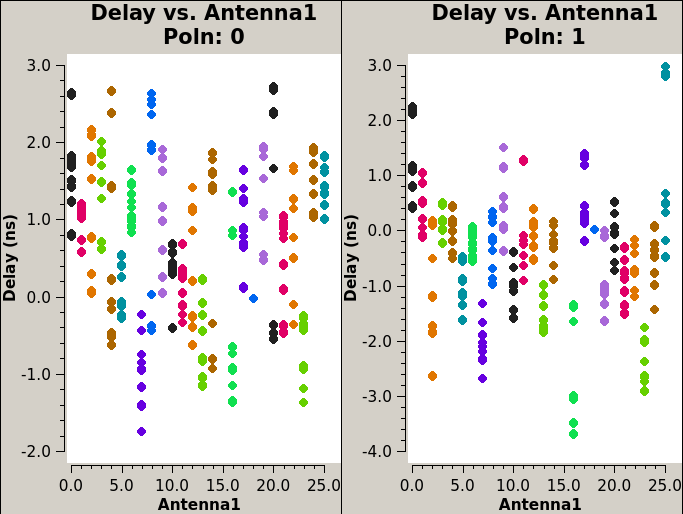

In [35]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [36]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [37]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [38]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flagging Summary
If no calibration solutions are available, data may be flagged (e.g. bad spectral windows).

In [41]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after initial calibration round {rnd}:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after initial calibration round 1:

field 3C147
Before: 74.4948, After: 74.4951

antenna ea01
Before: 72.3255, After: 72.3256

antenna ea02
Before: 72.2673, After: 72.2673

antenna ea03
Before: 72.2860, After: 72.2860

antenna ea04
Before: 72.2564, After: 72.2567

antenna ea05
Before: 72.2324, After: 72.2325

antenna ea06
Before: 72.3840, After: 72.3840

antenna ea07
Before: 72.3343, After: 72.3346

antenna ea08
Before: 72.3533, After: 72.3534

antenna ea09
Before: 72.3014, After: 72.3015

antenna ea10
Before: 72.3712, After: 72.3713

antenna ea11
Before: 72.2437, After: 72.2445

antenna ea12
Before: 72.6040, After: 72.6041

antenna ea13
Before: 72.2905, After: 72.2906

antenna ea14
Before: 72.2795, After: 72.2797

antenna ea15
Before: 72.2789, After: 72.2792

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 72.4077, After: 72.4078

antenna ea18
Before: 74.0175, After: 74.0210

antenna ea19
Before: 72.4060, After: 72.4060

antenna

## Second Round of Flagging
The flagging is repeated, but this time on all calibrators.

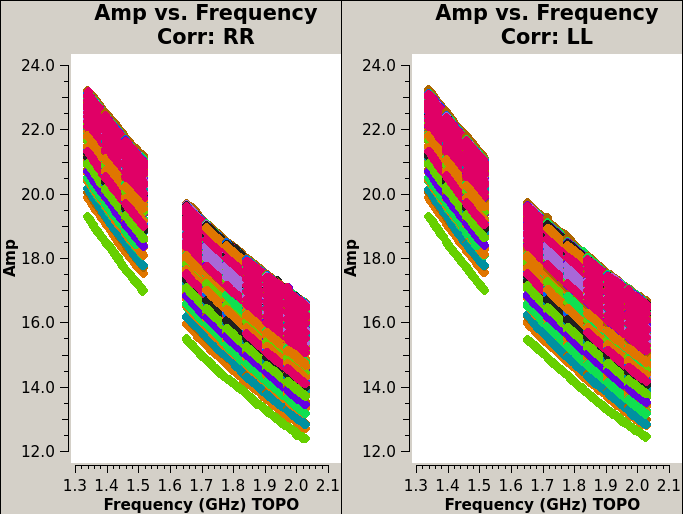

In [42]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

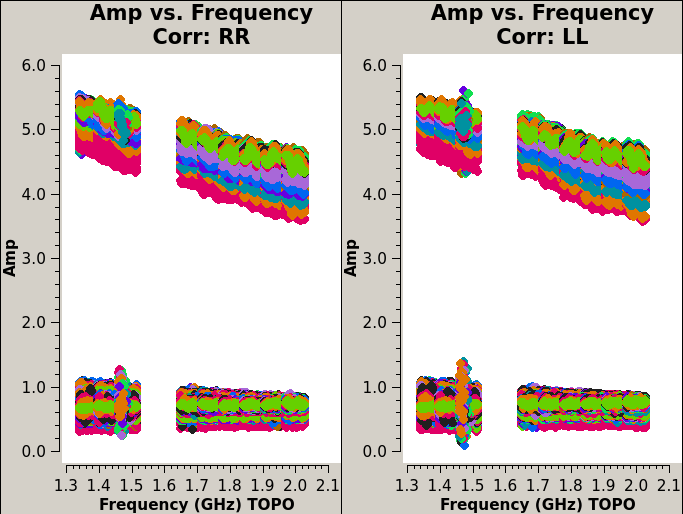

In [43]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

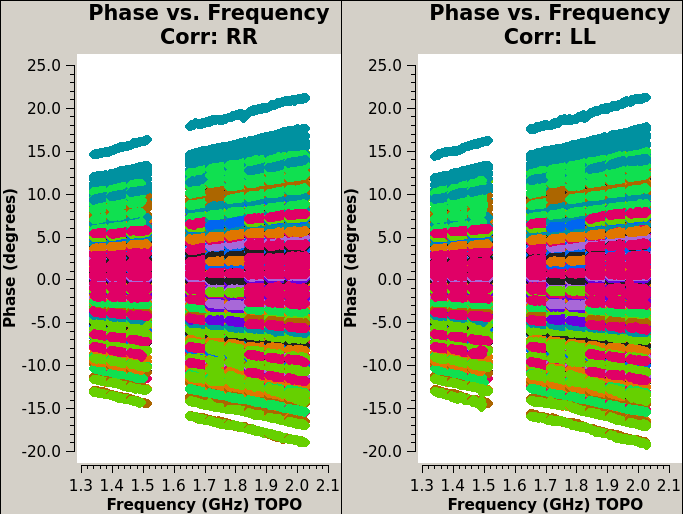

In [44]:
# primary calibrator
Image(filename=root + "/plots/dataplots/before_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

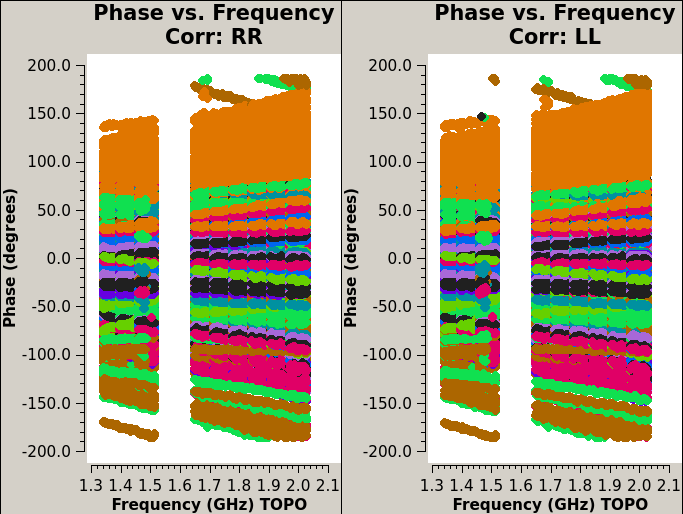

In [45]:
# phase calibrators
Image(filename=root + "/plots/dataplots/before_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### After Flagging

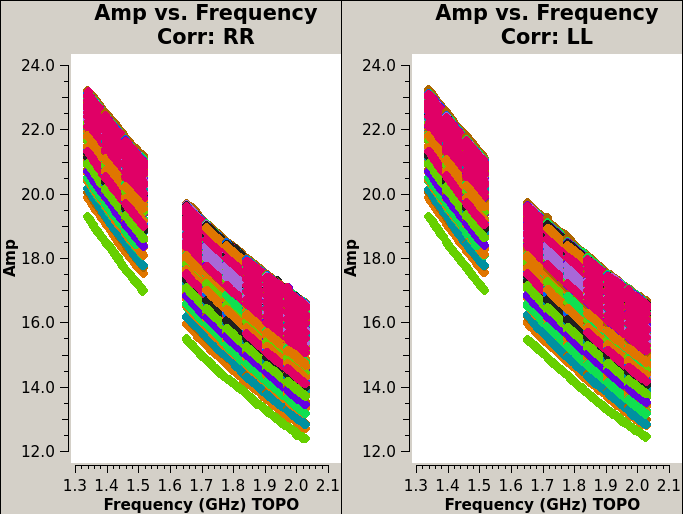

In [46]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_amp_vs_freq_CorrRR,LL.png")

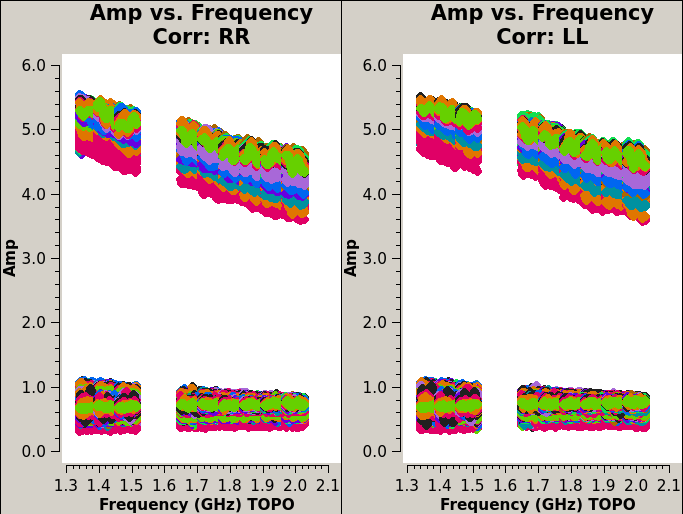

In [47]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

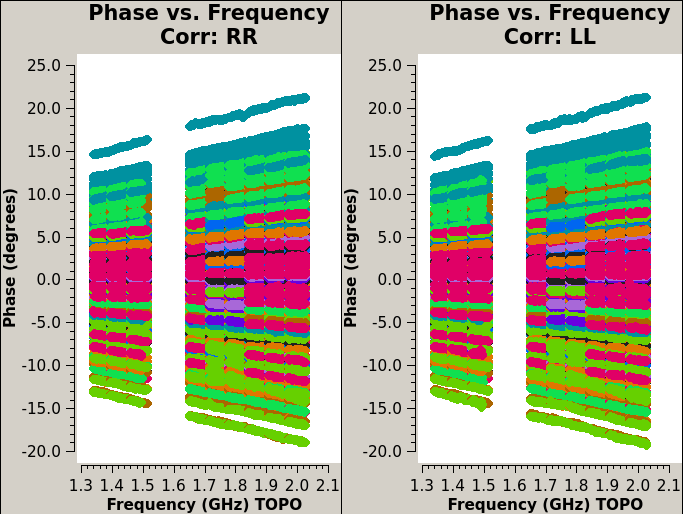

In [48]:
# primary calibrator
Image(filename=root + "/plots/dataplots/after_fluxcal_round_1_flagging_phase_vs_freq_CorrRR,LL.png")

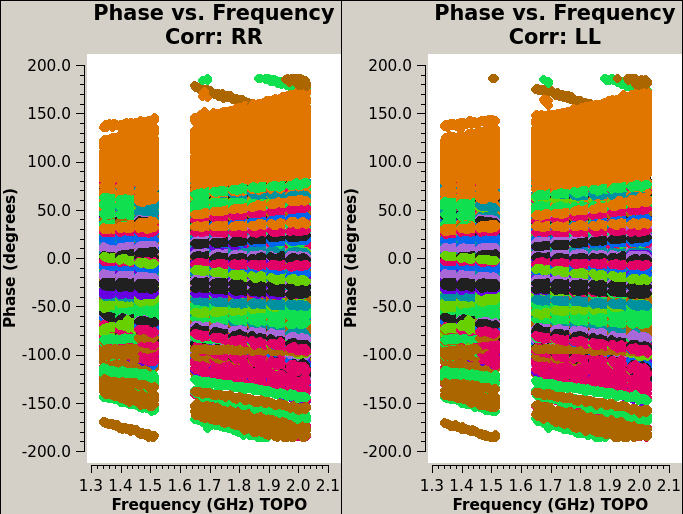

In [49]:
# phase calibrators
Image(filename=root + "/plots/dataplots/after_phasecal_round_0_flagging_phase_vs_freq_CorrRR,LL.png")

### Flagging Summary

In [50]:
summary_before = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/fluxcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the flux calibrator:

field 3C147
Before: 74.4951, After: 74.5084

scan 1
Before: 100.0000, After: 100.0000

scan 2
Before: 76.6149, After: 76.6277

scan 3
Before: 64.2612, After: 64.2786

antenna ea01
Before: 72.3256, After: 72.3306

antenna ea02
Before: 72.2673, After: 72.2719

antenna ea03
Before: 72.2860, After: 72.3013

antenna ea04
Before: 72.2567, After: 72.2720

antenna ea05
Before: 72.2325, After: 72.2364

antenna ea06
Before: 72.3840, After: 72.4164

antenna ea07
Before: 72.3346, After: 72.3540

antenna ea08
Before: 72.3534, After: 72.3623

antenna ea09
Before: 72.3015, After: 72.3063

antenna ea10
Before: 72.3713, After: 72.3891

antenna ea11
Before: 72.2445, After: 72.2551

antenna ea12
Before: 72.6041, After: 72.6303

antenna ea13
Before: 72.2906, After: 72.3109

antenna ea14
Before: 72.2797, After: 72.2944

antenna ea15
Before: 72.2792, After: 72.2878

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 7

In [51]:
summary_before = np.load(root + f"/output/phasecal_round_0_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_round_0_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging the phase calibrators:

field J1057-2433
Before: 74.1120, After: 74.5070

field J1130-1449
Before: 65.9782, After: 66.4347

field J1246-0730
Before: 66.4005, After: 66.9172

field J1309+1154
Before: 69.7353, After: 70.1497

field J1347+1217
Before: 66.1378, After: 66.6947

scan 10
Before: 66.6765, After: 67.1848

scan 12
Before: 65.9604, After: 66.4903

scan 13
Before: 74.1945, After: 74.5386

scan 16
Before: 64.3722, After: 64.8712

scan 17
Before: 69.7174, After: 70.2259

scan 19
Before: 61.8325, After: 62.4476

scan 4
Before: 76.9158, After: 77.2693

scan 6
Before: 66.2309, After: 66.7427

scan 7
Before: 69.2553, After: 69.6493

scan 9
Before: 62.0369, After: 62.5686

antenna ea01
Before: 66.1197, After: 66.4559

antenna ea02
Before: 66.4582, After: 66.8852

antenna ea03
Before: 66.4548, After: 67.1305

antenna ea04
Before: 66.4395, After: 66.8631

antenna ea05
Before: 66.0784, After: 66.5633

antenna ea06
Before: 66.4851, After: 67

In [52]:
summary_before = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/phasecal_MAD_clipping_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after flagging MAD clippting the phase calibrators:

field J1057-2433
Before: 73.9845, After: 74.0907

field J1130-1449
Before: 65.8003, After: 65.9364

field J1246-0730
Before: 66.2020, After: 66.3439

field J1309+1154
Before: 69.5235, After: 69.6361

field J1347+1217
Before: 65.7751, After: 65.9349

scan 10
Before: 66.5327, After: 66.6721

scan 12
Before: 65.6748, After: 65.8205

scan 13
Before: 74.0455, After: 74.1395

scan 16
Before: 64.0848, After: 64.2198

scan 17
Before: 69.5202, After: 69.6709

scan 19
Before: 61.2707, After: 61.4417

scan 4
Before: 76.8112, After: 76.9048

scan 6
Before: 66.0394, After: 66.1807

scan 7
Before: 69.0696, After: 69.1856

scan 9
Before: 61.8683, After: 62.0286

antenna ea01
Before: 65.9328, After: 66.0284

antenna ea02
Before: 66.2531, After: 66.3766

antenna ea03
Before: 66.1763, After: 66.3733

antenna ea04
Before: 66.2297, After: 66.3492

antenna ea05
Before: 65.8708, After: 66.0117

antenna ea06
Before: 66.1

## Final Calibration
First, the initial calibration (delay and bandpass) are repeated on the primary calibrator. Then, the final gains of the calibrators are derived.

### Specify Gain Tables

In [53]:
# specify calibration table names
rnd = 2
delay_init_table = f"{name}.p.G{rnd}"
delay_table = f"{name}.K{rnd}"
bandpass_init_table = f"{name}.ap.G{rnd}"
bandpass_table = f"{name}.B{rnd}"

fluxcal_phase_table = f"{name}_fluxcal_phase.Gfinal"
short_gain_table = f"{name}_short.Gfinal"
amp_gain_table = f"{name}_amp.Gfinal"
phase_gain_table = f"{name}_phase.Gfinal"

### Delay Initial Gain Calibration

In [54]:
def plot_delay_init_cal(ant):
    img = mpimg.imread(root + f"/plots/calplots/{delay_init_table}_ant_{ant}_Poln0,1.png")
    imgplot = plt.imshow(img)

interact(plot_delay_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_delay_init_cal(ant)>

### Delay Calibration

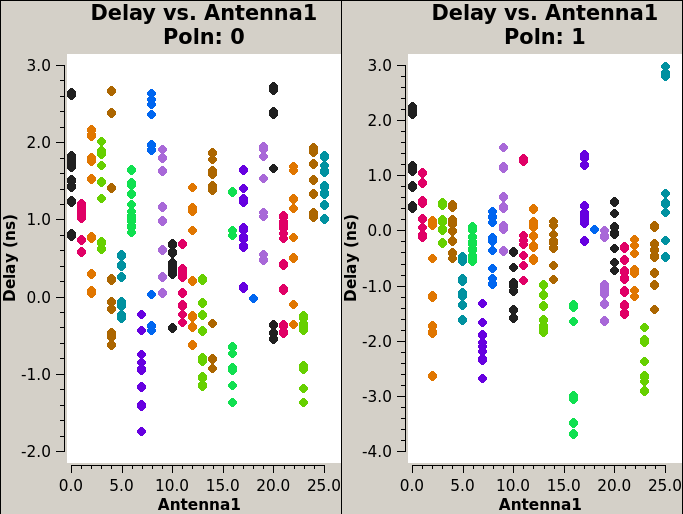

In [55]:
Image(filename=root + f"/plots/calplots/{delay_table}_Poln0,1.png")

### Bandpass Initial Gain Calibration

In [56]:
def plot_bandpass_init_cal(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_init_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_init_table}_phase_ant_{ant}_Poln0,1.png"
    )

interact(plot_bandpass_init_cal, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_init_cal(ant)>

### Bandpass Calibration

In [57]:
def plot_bandpass_ant(ant):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_ant_{ant}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_ant_{ant}_Poln0,1.png"
    )
    
interact(plot_bandpass_ant, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_bandpass_ant(ant)>

Iterate through spectral windows and colorise by antenna. 

In [58]:
def plot_bandpass_spw(spw):
    plot_two_cols(
        root + f"/plots/calplots/{bandpass_table}_amp_spw_{spw}_Poln0,1.png",
        root + f"/plots/calplots/{bandpass_table}_phase_spw_{spw}_Poln0,1.png"
    )

interact(plot_bandpass_spw, spw=(0, conf["spw"]-1))

interactive(children=(IntSlider(value=7, description='spw', max=15), Output()), _dom_classes=('widget-interact…

<function __main__.plot_bandpass_spw(spw)>

### Flux Calibrator Final Gain Phase

In [59]:
def plot_final_fluxcal_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{fluxcal_phase_table}_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_fluxcal_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_fluxcal_phase(ant)>

### Short Interval Gain Calibration
This is an initial calibration done on a per-integration basis on the calibrators.

In [60]:
def plot_final_short_gain_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{short_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_short_gain_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_short_gain_phase(ant)>

### Long Interval Gain Calibration
The gain amplitudes of the calibrators of solved for using the initial gain phase calibration above.

In [61]:
def plot_final_long_gain(ant):
    plot_two_cols(
        root + f'/plots/calplots/{amp_gain_table}_amp_ant_{ant}_Poln0,1.png',
        root + f'/plots/calplots/{amp_gain_table}_phase_ant_{ant}_Poln0,1.png'
    )

interact(plot_final_long_gain, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_long_gain(ant)>

### Phase Calibration
Derive the final gain phases of the calibrators. That of the primary calibrator should be close to zero, since it was already derived and applied earlier on.

In [62]:
def plot_final_phase(ant):
    img = mpimg.imread(root + f'/plots/calplots/{phase_gain_table}_phase_ant_{ant}_Poln0,1.png')
    plt.imshow(img)

interact(plot_final_phase, ant=(0, conf["ants"]-1))

interactive(children=(IntSlider(value=13, description='ant', max=26), Output()), _dom_classes=('widget-interac…

<function __main__.plot_final_phase(ant)>

### Flagging Summary

In [63]:
rnd=1
summary_before = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/initcal_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print(f"Flag occupancy (percent) before and after final delay and bandpass calibration:\n")

print_summary("field")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after final delay and bandpass calibration:

field 3C147
Before: 74.4948, After: 74.4951

antenna ea01
Before: 72.3255, After: 72.3256

antenna ea02
Before: 72.2673, After: 72.2673

antenna ea03
Before: 72.2860, After: 72.2860

antenna ea04
Before: 72.2564, After: 72.2567

antenna ea05
Before: 72.2324, After: 72.2325

antenna ea06
Before: 72.3840, After: 72.3840

antenna ea07
Before: 72.3343, After: 72.3346

antenna ea08
Before: 72.3533, After: 72.3534

antenna ea09
Before: 72.3014, After: 72.3015

antenna ea10
Before: 72.3712, After: 72.3713

antenna ea11
Before: 72.2437, After: 72.2445

antenna ea12
Before: 72.6040, After: 72.6041

antenna ea13
Before: 72.2905, After: 72.2906

antenna ea14
Before: 72.2795, After: 72.2797

antenna ea15
Before: 72.2789, After: 72.2792

antenna ea16
Before: 100.0000, After: 100.0000

antenna ea17
Before: 72.4077, After: 72.4078

antenna ea18
Before: 74.0175, After: 74.0210

antenna ea19
Before: 72.4060, After: 72.4060

In [64]:
summary_before = np.load(root + f"/output/applycal_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/applycal_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) before and after applying final calibration:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) before and after applying final calibration:

field 3C147
Before: 74.5115, After: 74.6542

field J1057-2433
Before: 74.5070, After: 74.5070

field J1130-1449
Before: 66.4347, After: 66.4347

field J1246-0730
Before: 66.9172, After: 66.9172

field J1309+1154
Before: 70.1497, After: 70.1497

field J1347+1217
Before: 66.6947, After: 66.6947

field QSO J1034-1425
Before: 61.2360, After: 61.2360

field QSO J1110-1329
Before: 60.4817, After: 60.4817

field QSO J1254-0014
Before: 61.6085, After: 61.6085

field QSO J1306+0356
Before: 61.0386, After: 61.0386

field QSO J1319+0950
Before: 60.2318, After: 60.2318

field QSO J1342+0928
Before: 59.7095, After: 59.7095

scan 1
Before: 100.0000, After: 100.0000

scan 10
Before: 67.1848, After: 67.1848

scan 11
Before: 61.6085, After: 61.6085

scan 12
Before: 66.4903, After: 66.4903

scan 13
Before: 74.5386, After: 74.5386

scan 14
Before: 61.0386, After: 61.0386

scan 15
Before: 60.2318, After: 60.2318

scan 16
Before: 64.871

## Target Flags
Now that the final calibration tables have been derived and applied to the data, the automated flagging routine is run on the target fields.

### Before Flagging

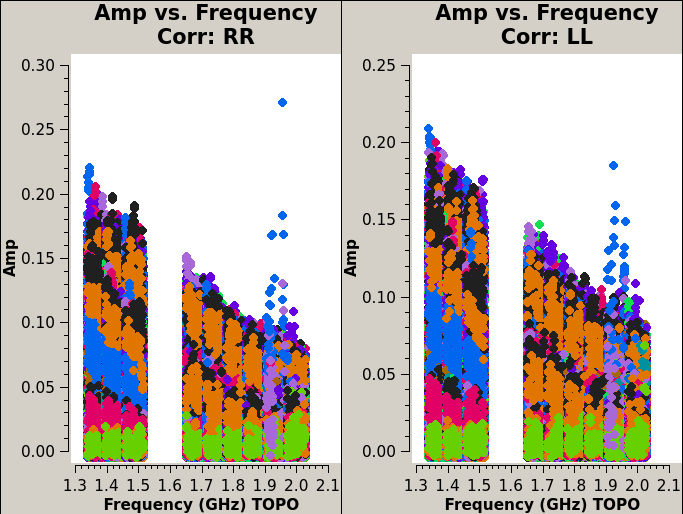

In [65]:
Image(filename=root + "/plots/dataplots/before_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### After Flagging

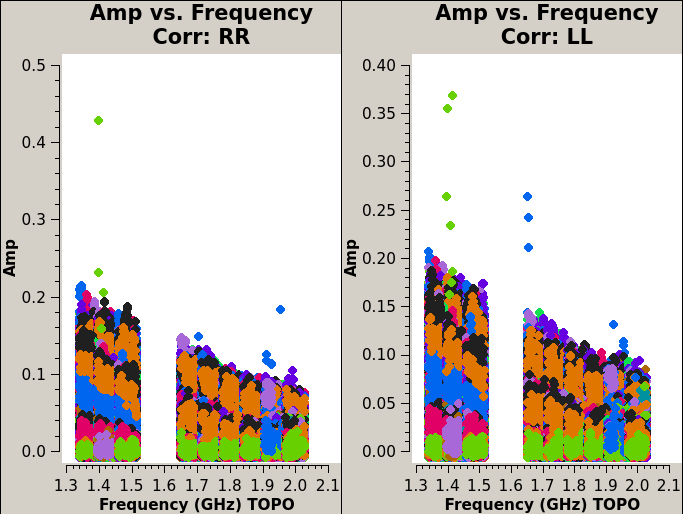

In [66]:
Image(filename=root + "/plots/dataplots/after_targets_round_0_flagging_amp_vs_freq_CorrRR,LL.png")

### Summary

In [67]:
rnd=0
summary_before = np.load(root + f"/output/targets_round_{rnd}_flags_summary_before.npy", allow_pickle='TRUE').item()
summary_after = np.load(root + f"/output/targets_round_{rnd}_flags_summary_after.npy", allow_pickle='TRUE').item()

print("Flag occupancy (percent) after flagging the flux calibrator:\n")

print_summary("field")
print_summary("scan")
print_summary("antenna")
print_summary("spw")

Flag occupancy (percent) after flagging the flux calibrator:

field QSO J1034-1425
Before: 61.2360, After: 61.7201

field QSO J1110-1329
Before: 60.4817, After: 60.9358

field QSO J1254-0014
Before: 61.6085, After: 62.3758

field QSO J1306+0356
Before: 61.0386, After: 61.3735

field QSO J1319+0950
Before: 60.2318, After: 60.6934

field QSO J1342+0928
Before: 59.7095, After: 60.1329

scan 11
Before: 61.6085, After: 62.3758

scan 14
Before: 61.0386, After: 61.3735

scan 15
Before: 60.2318, After: 60.6934

scan 18
Before: 59.7095, After: 60.1329

scan 5
Before: 61.2360, After: 61.7201

scan 8
Before: 60.4817, After: 60.9358

antenna ea01
Before: 57.0968, After: 57.4022

antenna ea02
Before: 57.0522, After: 57.4716

antenna ea03
Before: 57.0525, After: 57.7916

antenna ea04
Before: 57.5076, After: 57.9415

antenna ea05
Before: 56.7582, After: 57.1850

antenna ea06
Before: 57.2303, After: 57.8199

antenna ea07
Before: 56.7399, After: 57.0581

antenna ea08
Before: 57.4267, After: 57.9173

an

## Summary Plots
These plots show the corrected amplitudes and phases of all fields as a function of uv-distance and frequency. The values plotted against uv-distance are colorised by spectral window while those plotted against frequency are colorised by antenna number. Remaining RFI should be flagged manually in CASA.

In [68]:
field_dict = vladata.get_field_names(ms)
fields = field_dict["calibrators"] + "," + field_dict["targets"]

3C147


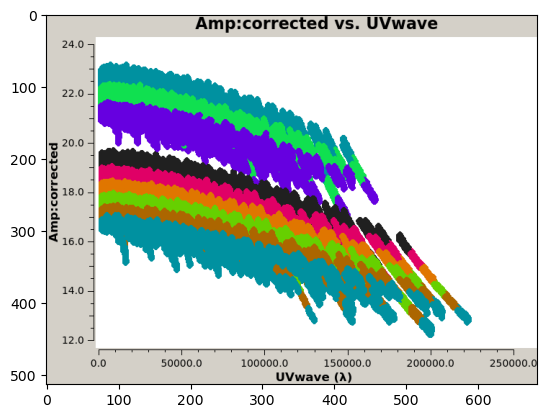

J1057-2433


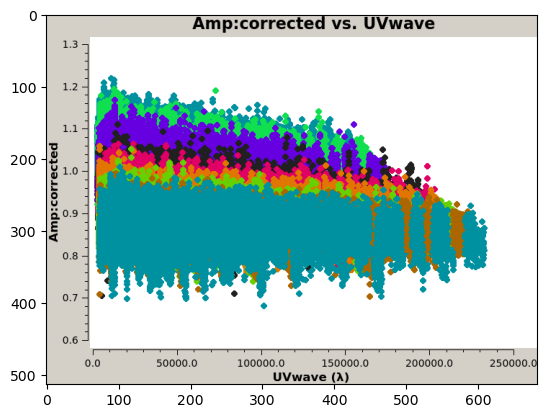

J1130-1449


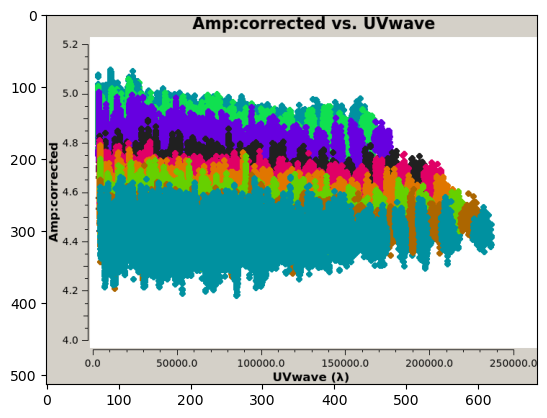

J1246-0730


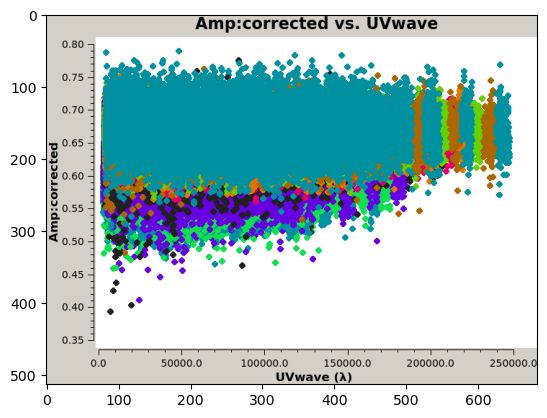

J1309+1154


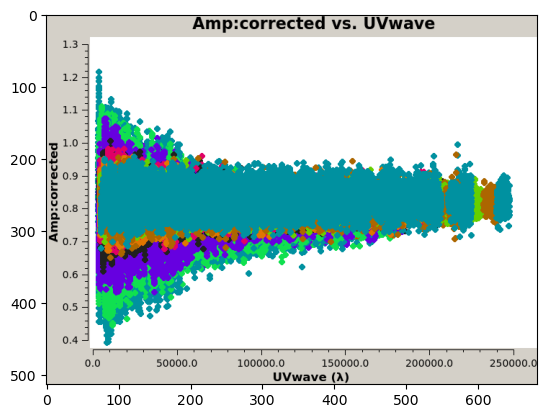

J1347+1217


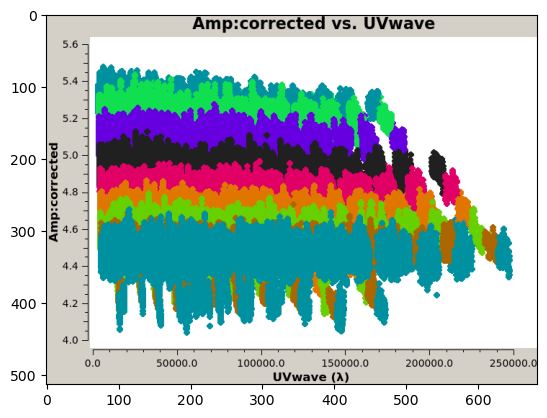

QSO J1034-1425


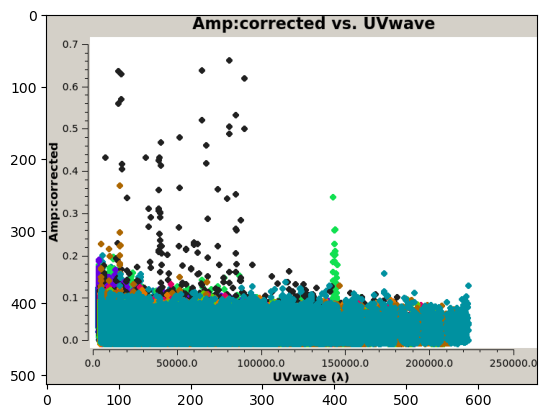

QSO J1110-1329


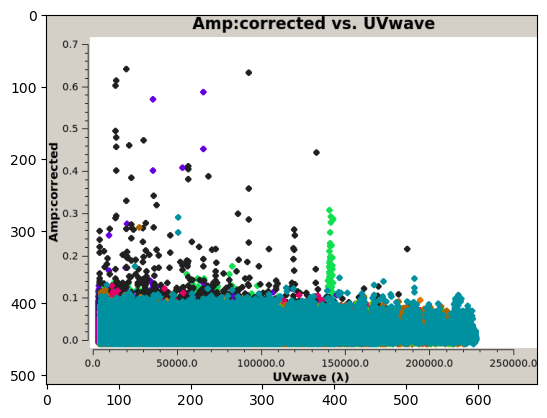

QSO J1254-0014


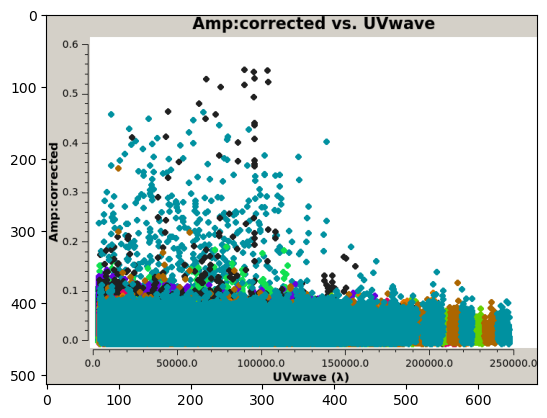

QSO J1306+0356


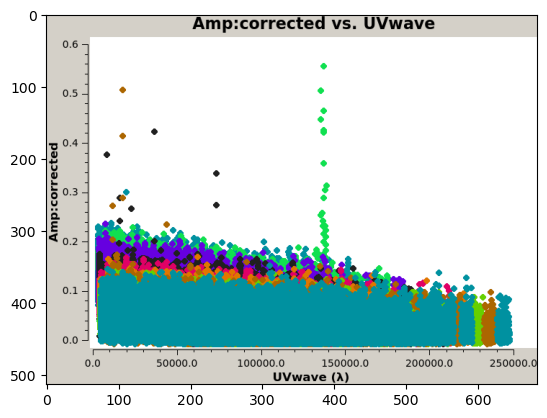

QSO J1319+0950


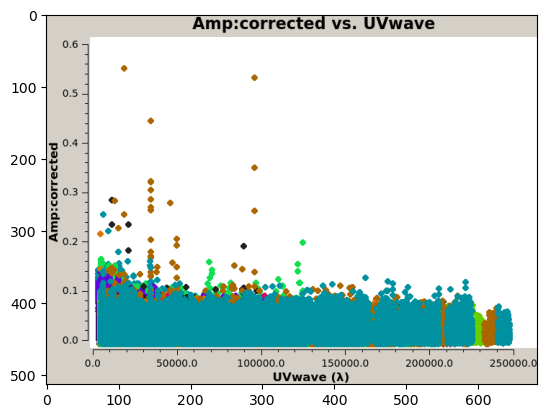

QSO J1342+0928


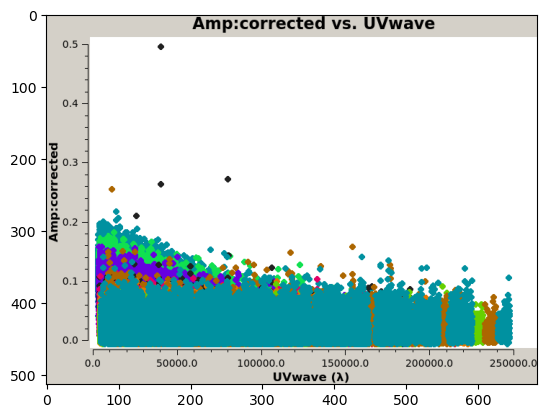

In [69]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_uvdist_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

3C147


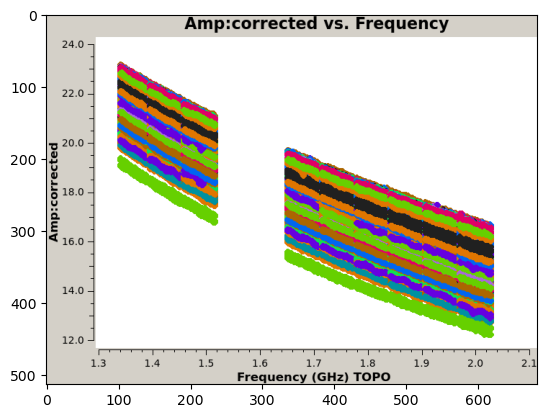

J1057-2433


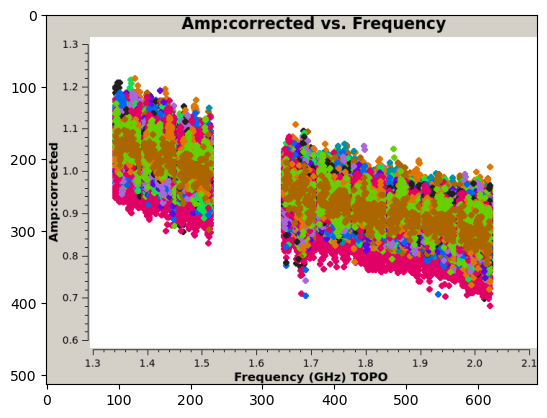

J1130-1449


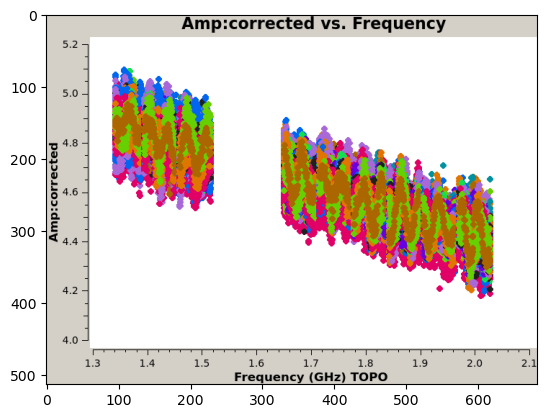

J1246-0730


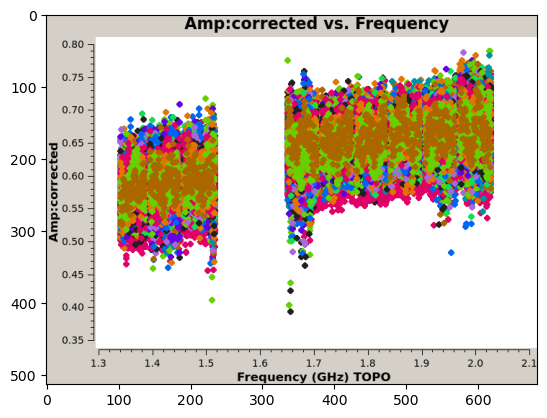

J1309+1154


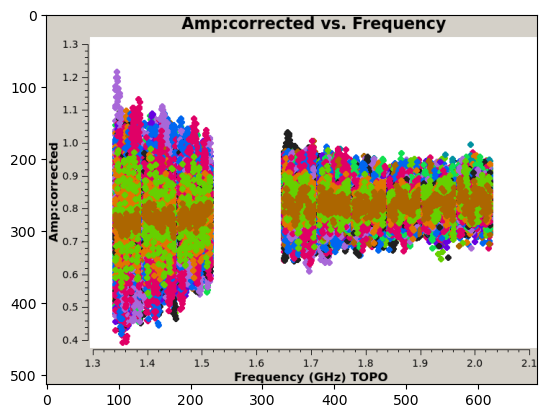

J1347+1217


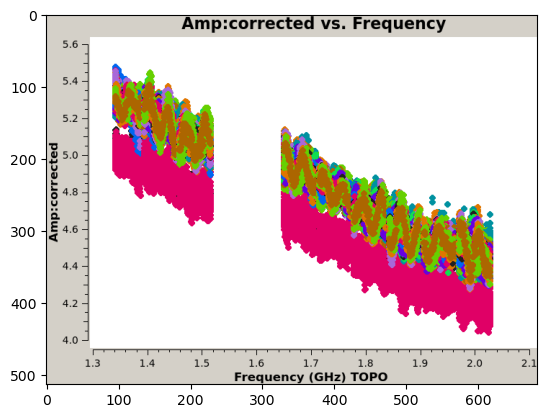

QSO J1034-1425


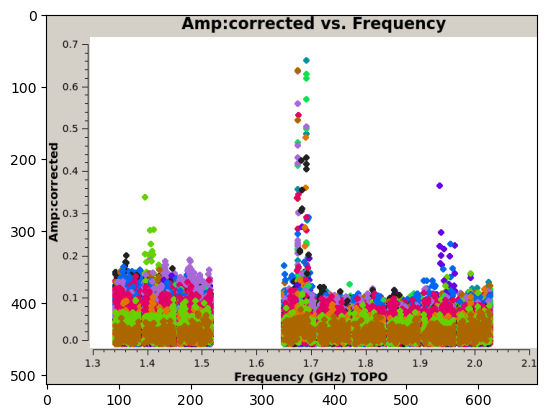

QSO J1110-1329


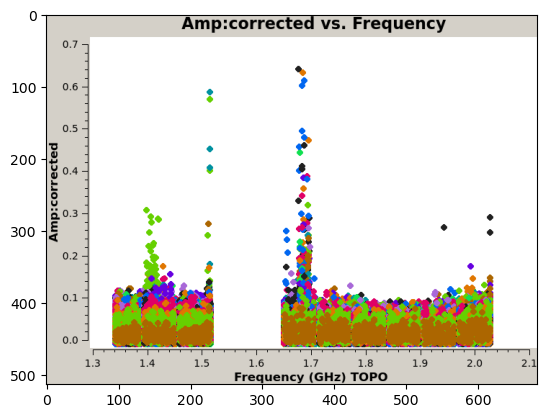

QSO J1254-0014


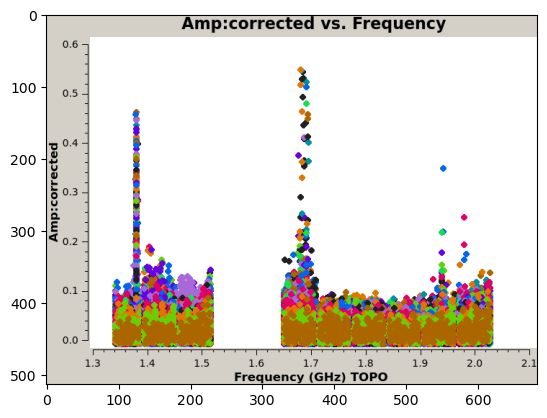

QSO J1306+0356


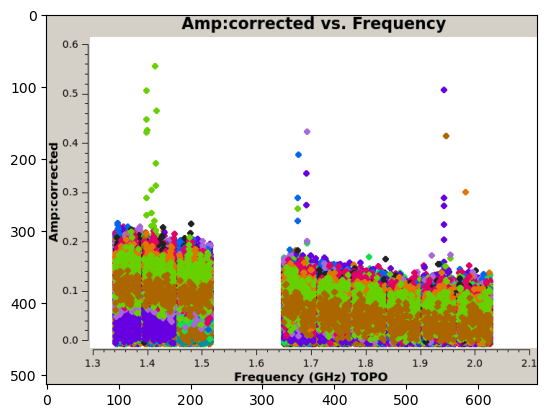

QSO J1319+0950


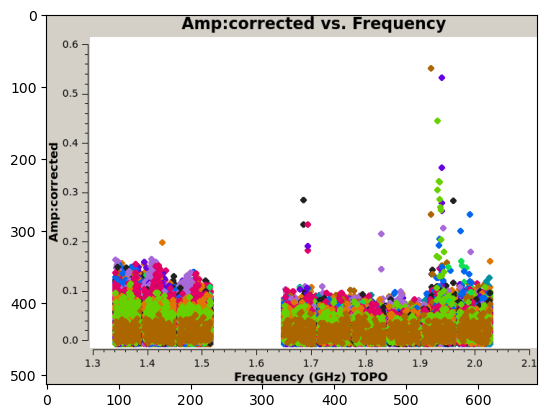

QSO J1342+0928


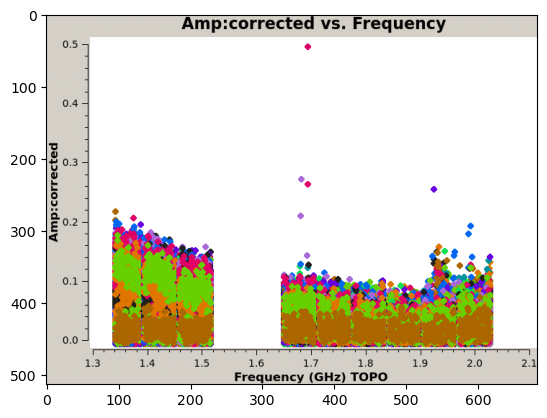

In [70]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_amp_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

3C147


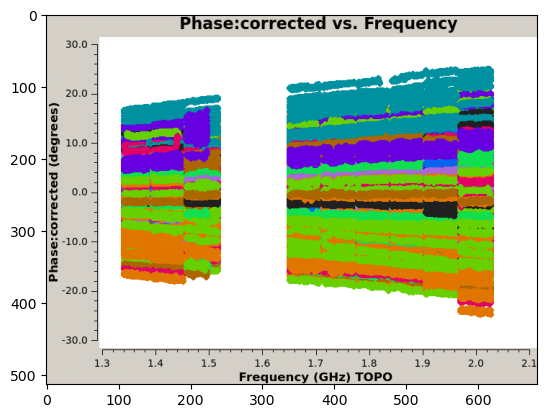

J1057-2433


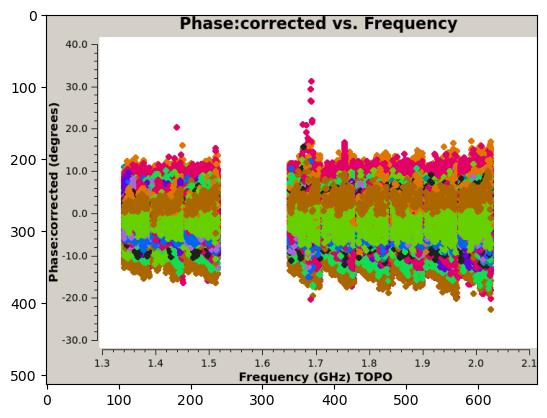

J1130-1449


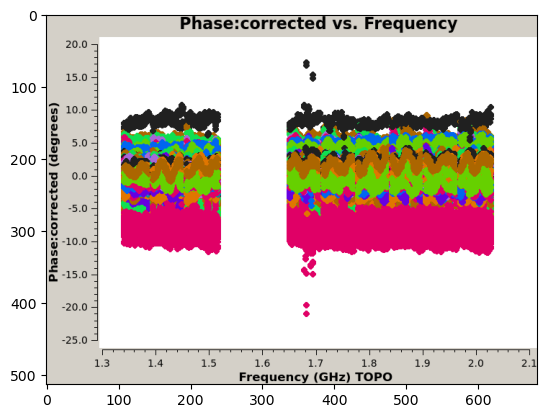

J1246-0730


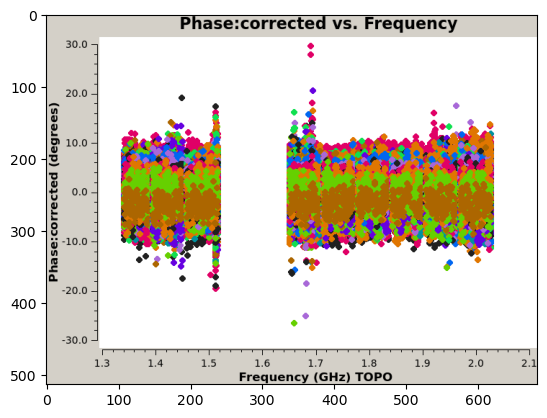

J1309+1154


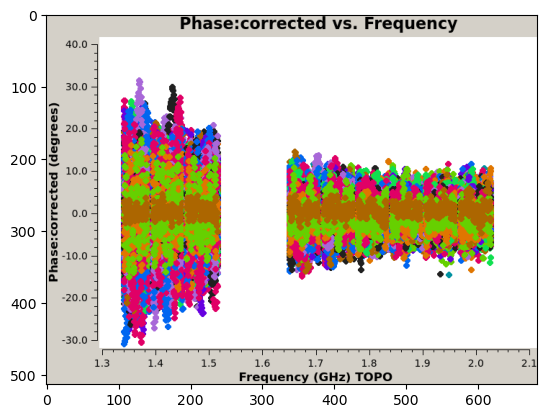

J1347+1217


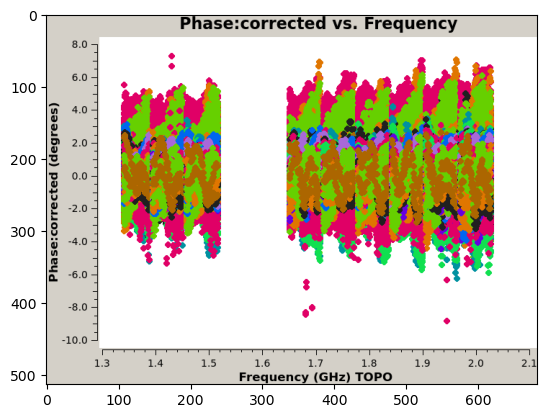

QSO J1034-1425


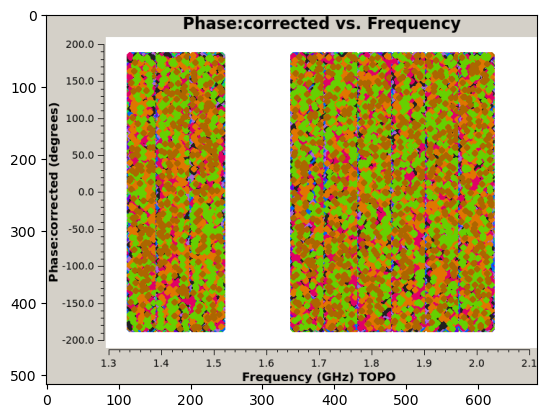

QSO J1110-1329


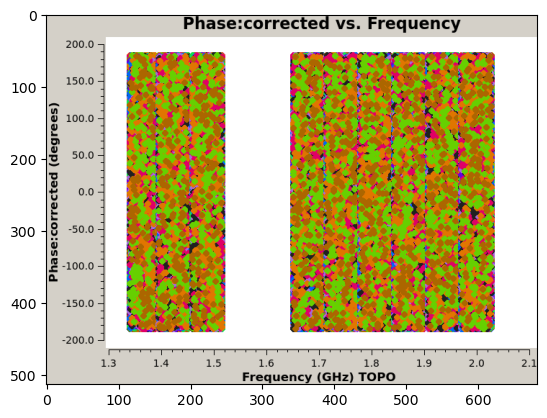

QSO J1254-0014


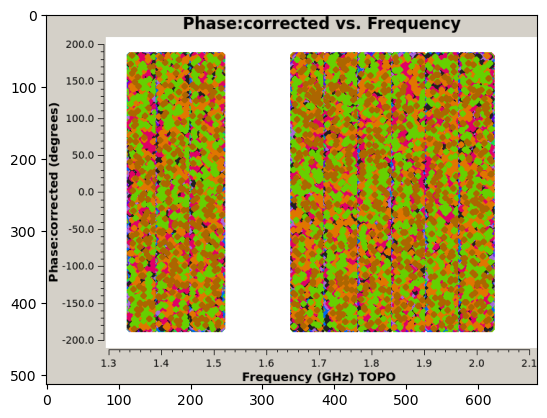

QSO J1306+0356


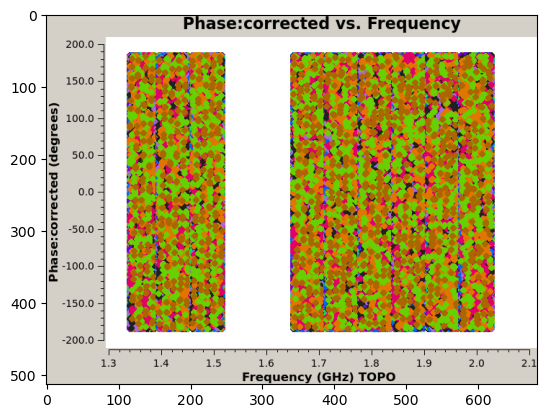

QSO J1319+0950


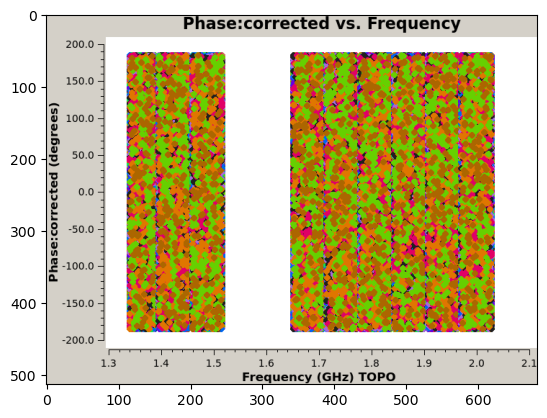

QSO J1342+0928


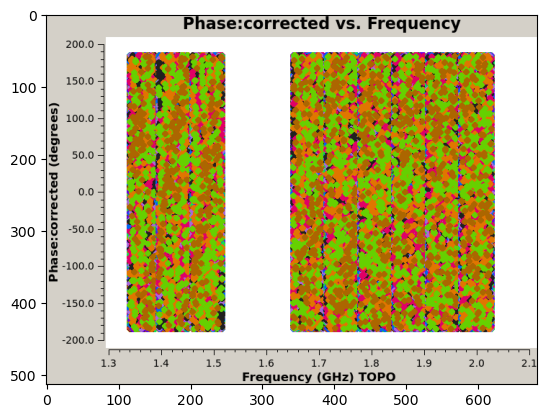

In [71]:
for field in fields.split(","):
    print(field)
    img = mpimg.imread(root + f"/plots/dataplots/{field}_phase_vs_freq_corrected.png")
    imgplot = plt.imshow(img)
    plt.show()

In [72]:

with h5py.File(root + f"/output/z_score_corrected.h5", "r") as f:
    z_score = f["z-score avg"][()]
    flags = f["flags avg"][()]
    freq_array = f["freq array"][()]
    time_array = f["time array"][()]
    ant_pairs = f["ant pairs"][()]
    dt = f["dt"][()]

# Load time integrations per scan
ntimes_file = os.path.join(root, f"output/ntimes.txt")
ntimes = np.loadtxt(ntimes_file).astype(int)

# time array
tisot = np.unique(Time(time_array, format="jd", scale="utc").isot)

z_score = np.ma.masked_array(z_score, mask=flags)

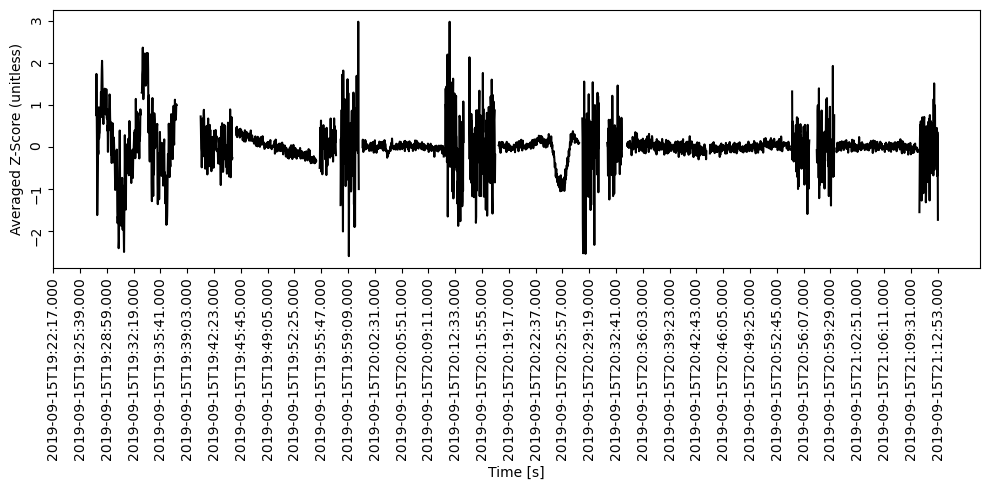

In [73]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(10, 5), sharex=True)
ax = inspect.plot_time_series(tisot, np.ma.median(z_score, axis=1), ax, plot_masked=True)
ax.set_ylabel("Averaged Z-Score (unitless)")
ax.set_xticks(tisot[::100])
plt.tight_layout()

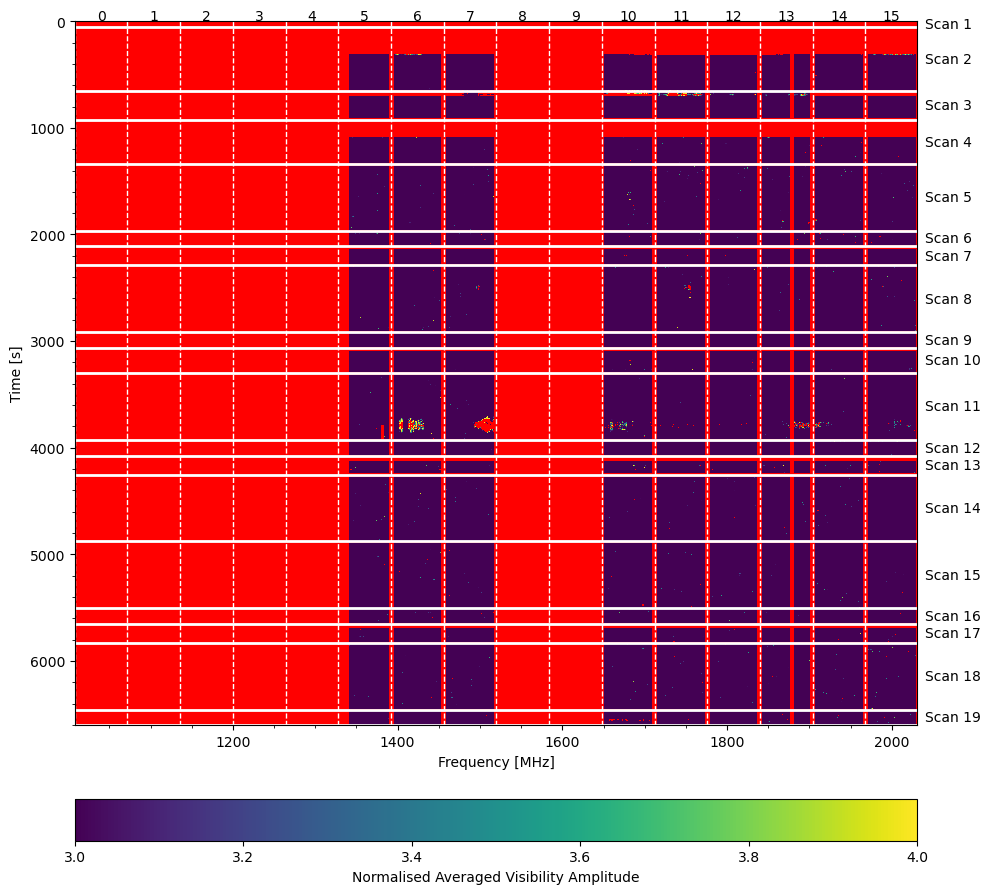

In [74]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
ax, im = inspect.plot_wf(freq_array, z_score, 2, ntimes, vmin=3, vmax=4, cmap=cmap, ax=ax, plot_masked=True)
fig.colorbar(im, orientation="horizontal", pad=0.08, label="Normalised Averaged Visibility Amplitude")